Create a model with piecewise warps, and use the ground truth model to synthesize data. 

Status:
- Mostly works but a few trials misaligned
- Need to check optimization code:
- Fix template, fit warps
- Fix warps, fit template
- Check alternating optimization

Other ideas if warp fitting is a problem:
- Alternative parameterization
- Different temperature decay schedules
- Ensembling

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from affinewarp import PiecewiseWarping

Populating the interactive namespace from numpy and matplotlib


In [2]:
n_knots = 1
model = PiecewiseWarping(n_knots=n_knots)

In [3]:
n_trials = 30
n_time = 100
n_neuron = 10
model.initialize_warps(n_trials)
model.x_knots, model.y_knots = model._mutate_knots(0.1);
model.y_knots[:, 0] = 0.
model.y_knots[:, -1] = 1.

(0, 1)

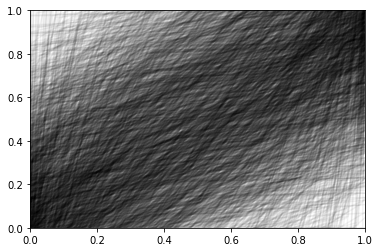

In [4]:
for _ in range(100):
    x, y = model._mutate_knots(0.5);
    plot(x.T, y.T, c='k', alpha=0.05);
ylim(0, 1)
xlim(0, 1)

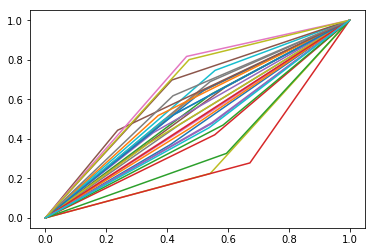

In [5]:
plot(model.x_knots.T, model.y_knots.T);

In [6]:
template = np.random.rand(n_time, n_neuron)
from scipy.ndimage import gaussian_filter1d
template_sigma = n_time / 50.
template = gaussian_filter1d(template, template_sigma, axis=0)
template[:n_time//4] = 0 # zero-pad boundaries
template[3*n_time//4:] = 0
aligned_data = np.tile(template[None, ...], (n_trials, 1, 1))
data = model.transform(aligned_data)

In [7]:
model.template = template
data = model.predict()

In [8]:
from affinewarp.visualization import binned_heatmap

In [9]:
model_fit = PiecewiseWarping(n_knots=n_knots,l2_reg_scale=0.0,max_temp=-1., smoothness_reg_scale=0.0)
model_fit.copy_fit(model)
#model_fit.template = None
#model_fit.template = np.random.rand(*model_fit.template.shape)
#model_fit.x_knots, model_fit.y_knots = model_fit._mutate_knots(1.0)
model_fit.fit(data, iterations=500, warp_iterations=200, fit_template=False)

100%|██████████| 500/500 [00:12<00:00, 40.75it/s]


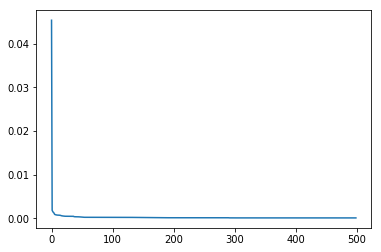

In [10]:
plot(model_fit.loss_hist)

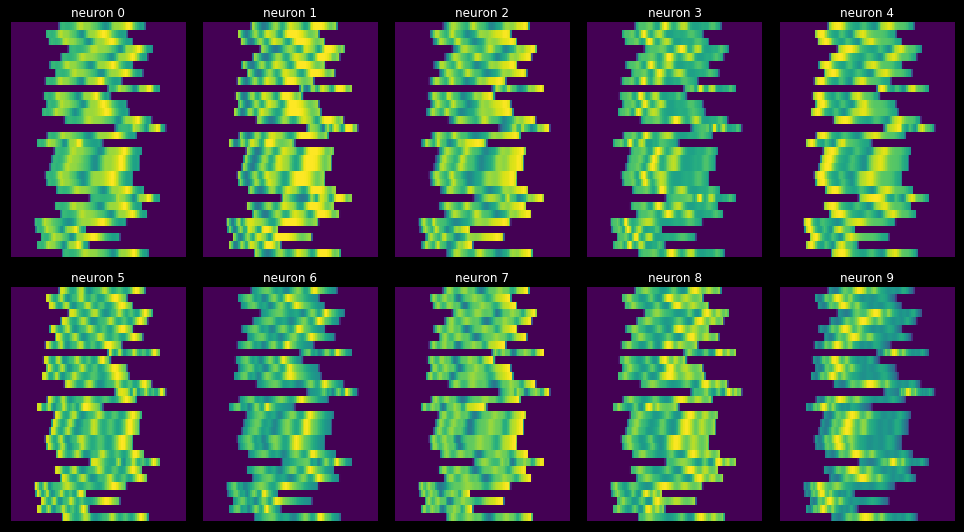

In [11]:
binned_heatmap((data), subplots=(2,5));

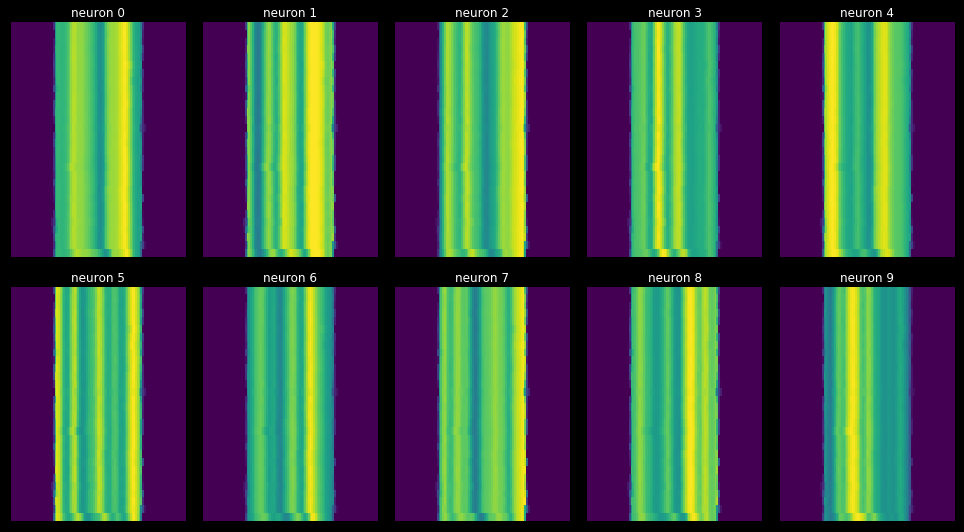

In [12]:
binned_heatmap(model_fit.transform(data), subplots=(2,5));

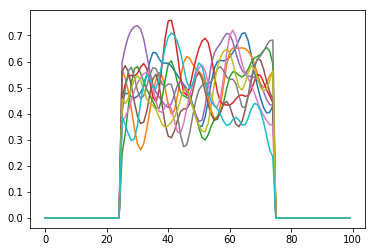

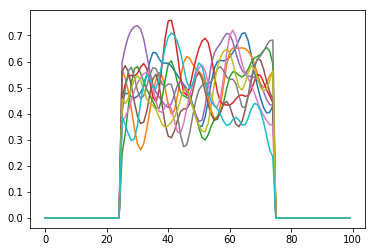

In [13]:
plot(model.template); show()
plot(model_fit.template)

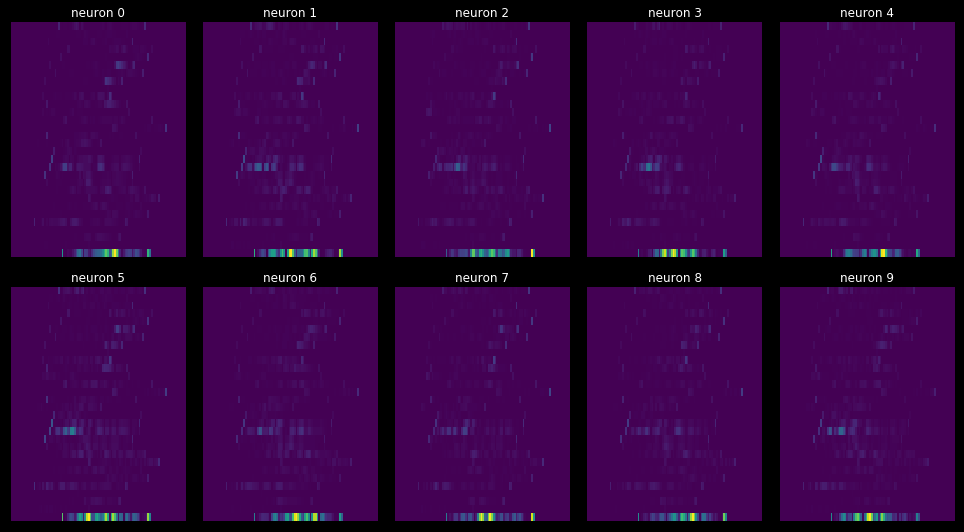

In [14]:
binned_heatmap(np.abs(model_fit.predict()-data), subplots=(2,5));

## Evaluate loss as we move middle x-y knot

In [15]:
true_x_knots, true_y_knots = model.x_knots, model.y_knots

In [16]:
trial_losses = np.sum(np.abs(model_fit.predict()-data), (1,2))
worst_trial = np.argmax(trial_losses)

In [17]:
nx = 100
eps = 1e-9

learned_x, learned_y = model_fit.x_knots[worst_trial, 1], model_fit.y_knots[worst_trial, 1]

learned_x = 0.5
learned_y = 0.5
dx = 0.4
xx = np.linspace(learned_x-dx, learned_x+dx, nx)
yy = np.linspace(learned_y-dx, learned_y+dx, nx)
xs, ys = np.meshgrid(xx, yy)
model.loss_hist = []
model.warp_reg_scale = 0.0
model._initialize_storage(n_trials)
for x, y in zip(xs.ravel(), ys.ravel()):
    model.x_knots[worst_trial, 1] = x
    model.y_knots[worst_trial, 1] = y
    model._record_loss(data)

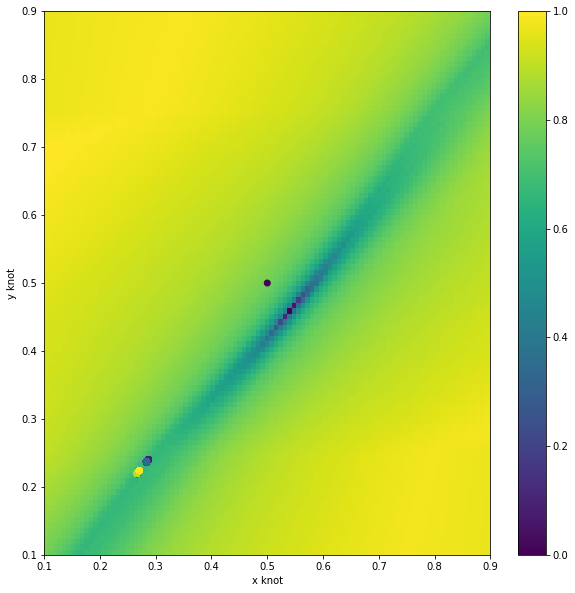

In [20]:
figure(figsize=(10,10))
losses = np.reshape(model.loss_hist, (nx, nx))
pcolor(xs, ys, np.log(losses));

knots = np.array(list(map(lambda xy: (xy[0][worst_trial, 1], xy[1][worst_trial, 1]), model_fit._knot_hist)))

c = np.linspace(0, 1, knots.shape[0])
scatter(knots[:, 0], knots[:, 1], c=c)
#plot(model_fit.x_knots[worst_trial, 1], model_fit.y_knots[worst_trial, 1], 'o', markersize=10)
xlabel('x knot')
ylabel('y knot')
colorbar()

model.

In [19]:
plot(model.x_knots.T - model.x, model.y_knots.T);

AttributeError: 'PiecewiseWarping' object has no attribute 'x'

In [ ]:
imshow(model_fit.template, aspect='auto')

In [ ]:
imshow(model.template, aspect='auto')